In [1]:
from data import get_data, create_pairs
from enlarge_data import get_enlarge_data
from model import *
from train import train
from sklearn.metrics import accuracy_score
from print_stats import *
import numpy as np
from tensorflow.keras.utils import plot_model

2024-05-18 11:46:07.730979: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 11:46:07.774724: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 11:46:07.774752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 11:46:07.774762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 11:46:07.781438: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Defining the size of the image after transformation
img_size = (100, 100)

# Split to get the training, testing, and validation datasets with 80:0:20 ratio.
# Random seed has been hard coded in data.py, set to "42"
data, train_indices, test_indices, val_indices = get_data(img_size=img_size, preprocessing='None')

train_data = []
train_data_indices = []
for person in train_indices:
    train_data_indices.append(list(range(len(train_data), len(train_data) + len(person))))
    train_data.extend([data[idx] for idx in person])
train_data = tf.convert_to_tensor(train_data)

# Test Prints
print(f"{np.array(data).shape = }")

100%|██████████| 44/44 [01:39<00:00,  2.27s/it]


np.array(data).shape = (1453, 100, 100, 3)


In [4]:
from tqdm import tqdm
from score import get_best_idx_compatibility

def compute_all_pred(model):
    pred_median = []
    pred_mean = []
    pred_max = []
    pred_min = []

    real = []

    indices = list(enumerate(val_indices))
    for real_idx, hand_indices in tqdm(indices):

        for hand_idx in hand_indices:
            pred = get_best_idx_compatibility(model, train_data, train_data_indices, data[hand_idx], method="all")

            pred_median.append(pred[0])
            pred_mean.append(pred[1])
            pred_max.append(pred[2])
            pred_min.append(pred[3])

            real.append(real_idx)

    return real, pred_max, pred_min, pred_mean, pred_median

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cm_and_accuracies(model):
    real, pred_max, pred_min, pred_mean, pred_median = compute_all_pred(model)
    
    cm_max = confusion_matrix(real, pred_max)
    cm_min = confusion_matrix(real, pred_min)
    cm_mean = confusion_matrix(real, pred_mean)
    cm_median = confusion_matrix(real, pred_median)

    # Create a 2 by 2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    tick_labels = np.unique(real)

    # Plot cm_median
    sns.heatmap(cm_median, annot=True, fmt='g', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_title('Median Confusion Matrix')

    # Plot cm_max
    sns.heatmap(cm_max, annot=True, fmt='g', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels, ax=axes[0, 1])
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('True')
    axes[0, 1].set_title('Max Confusion Matrix')

    # Plot cm_min
    sns.heatmap(cm_min, annot=True, fmt='g', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('True')
    axes[1, 0].set_title('Min Confusion Matrix')

    # Plot cm_mean
    sns.heatmap(cm_mean, annot=True, fmt='g', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('True')
    axes[1, 1].set_title('Mean Confusion Matrix')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    max_accuracy = np.equal(real, pred_max).astype(int).mean()
    min_accuracy = np.equal(real, pred_min).astype(int).mean()
    mean_accuracy = np.equal(real, pred_mean).astype(int).mean()
    median_accuracy = np.equal(real, pred_median).astype(int).mean()

    print(f"{max_accuracy = }")
    print(f"{min_accuracy = }")
    print(f"{mean_accuracy = }")
    print(f"{median_accuracy = }")

100%|██████████| 42/42 [01:56<00:00,  2.77s/it]


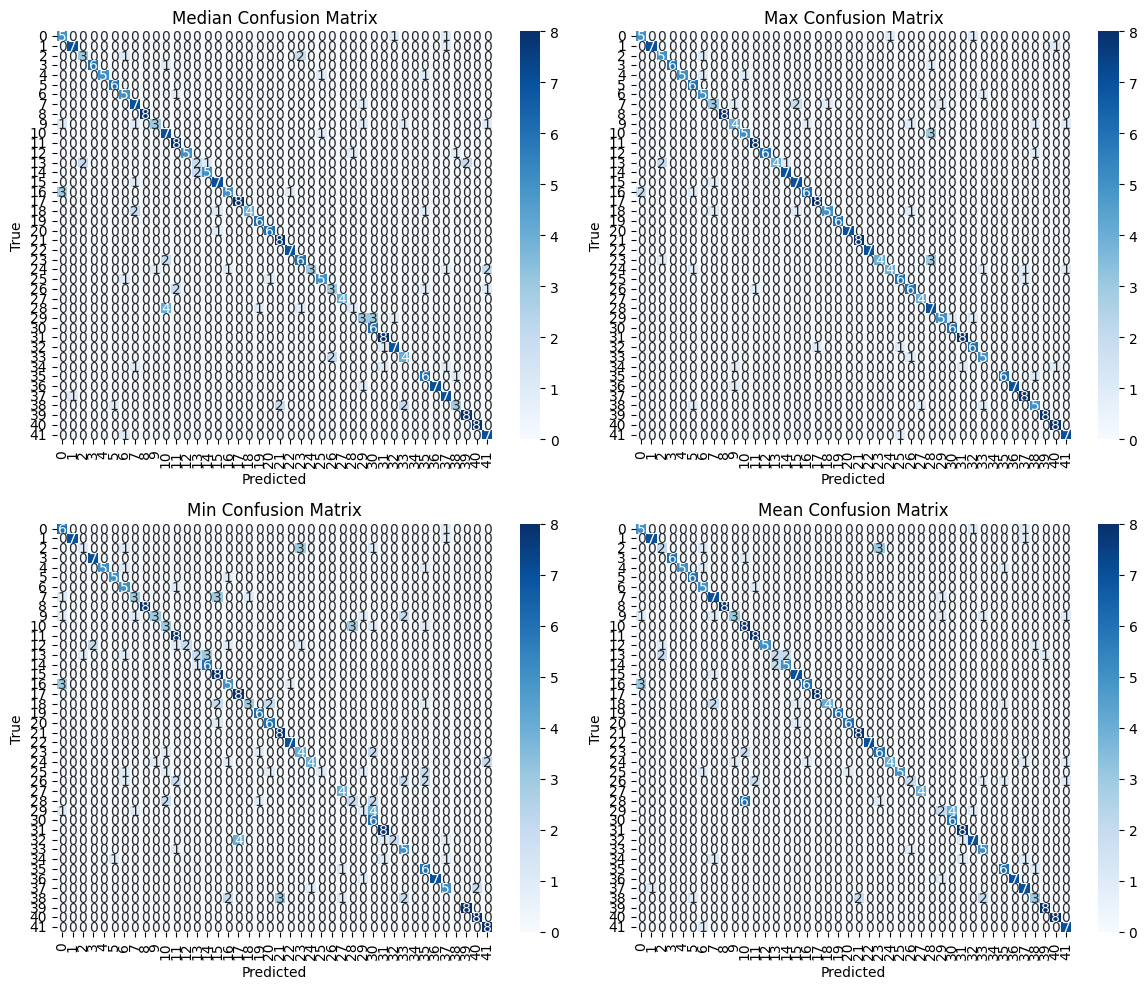

max_accuracy = 0.8184818481848185
min_accuracy = 0.6633663366336634
mean_accuracy = 0.7557755775577558
median_accuracy = 0.7557755775577558


In [11]:
model = dual_model((100, 100, 3), simple_model)
model.load_weights('Weights/Experiment 1/weights.49-0.34.weights.h5')

plot_cm_and_accuracies(model)

  0%|          | 0/42 [00:00<?, ?it/s]2024-05-18 09:36:33.650852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8903
2024-05-18 09:36:35.742101: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-18 09:36:35.975684: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-18 09:36:48.205964: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that

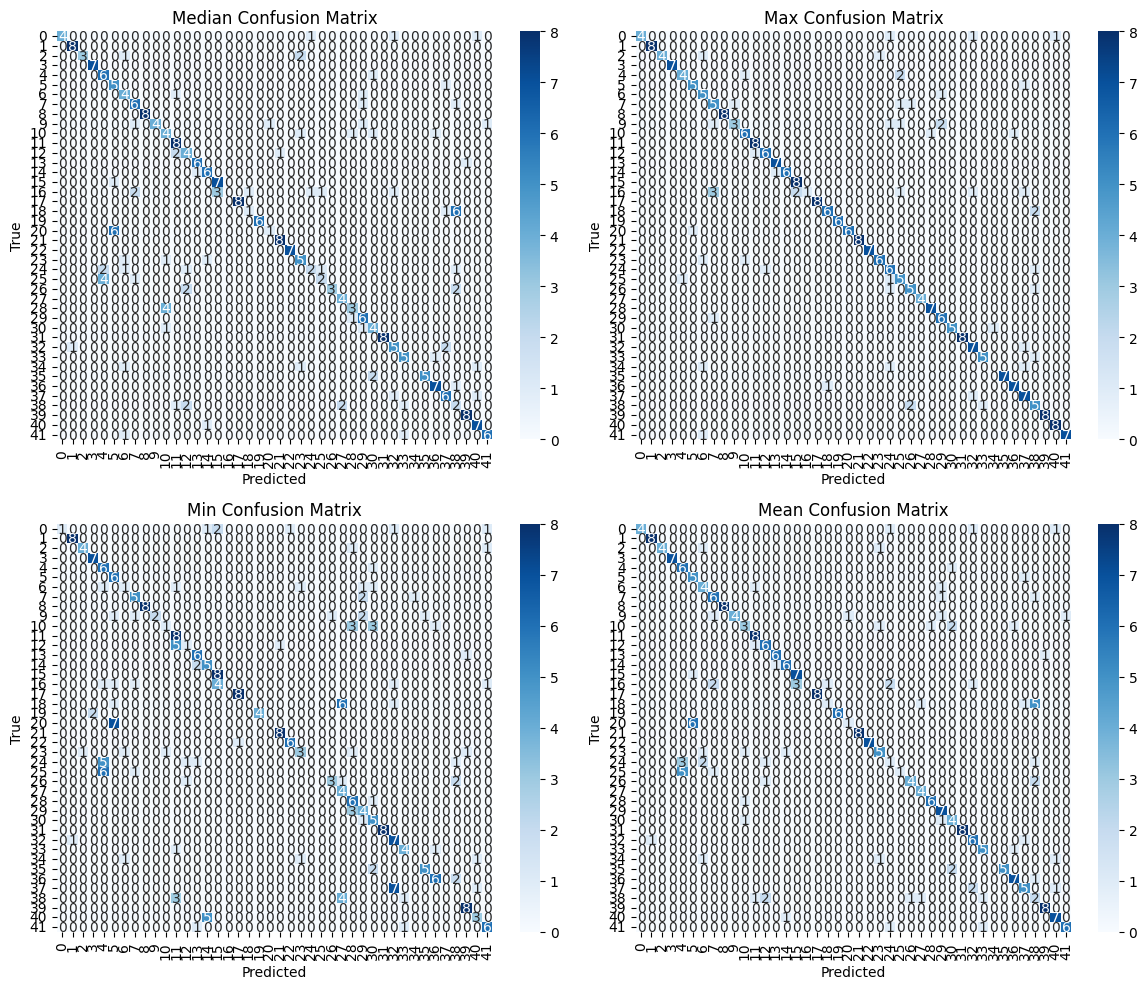

max_accuracy = 0.8217821782178217
min_accuracy = 0.5775577557755776
mean_accuracy = 0.7062706270627063
median_accuracy = 0.6897689768976898


In [9]:
model = dual_model((100, 100, 3), big_cnn_model)
model.load_weights('Weights/Experiment 2/weights.41-0.37.weights.h5')

plot_cm_and_accuracies(model)

100%|██████████| 42/42 [01:02<00:00,  1.50s/it]


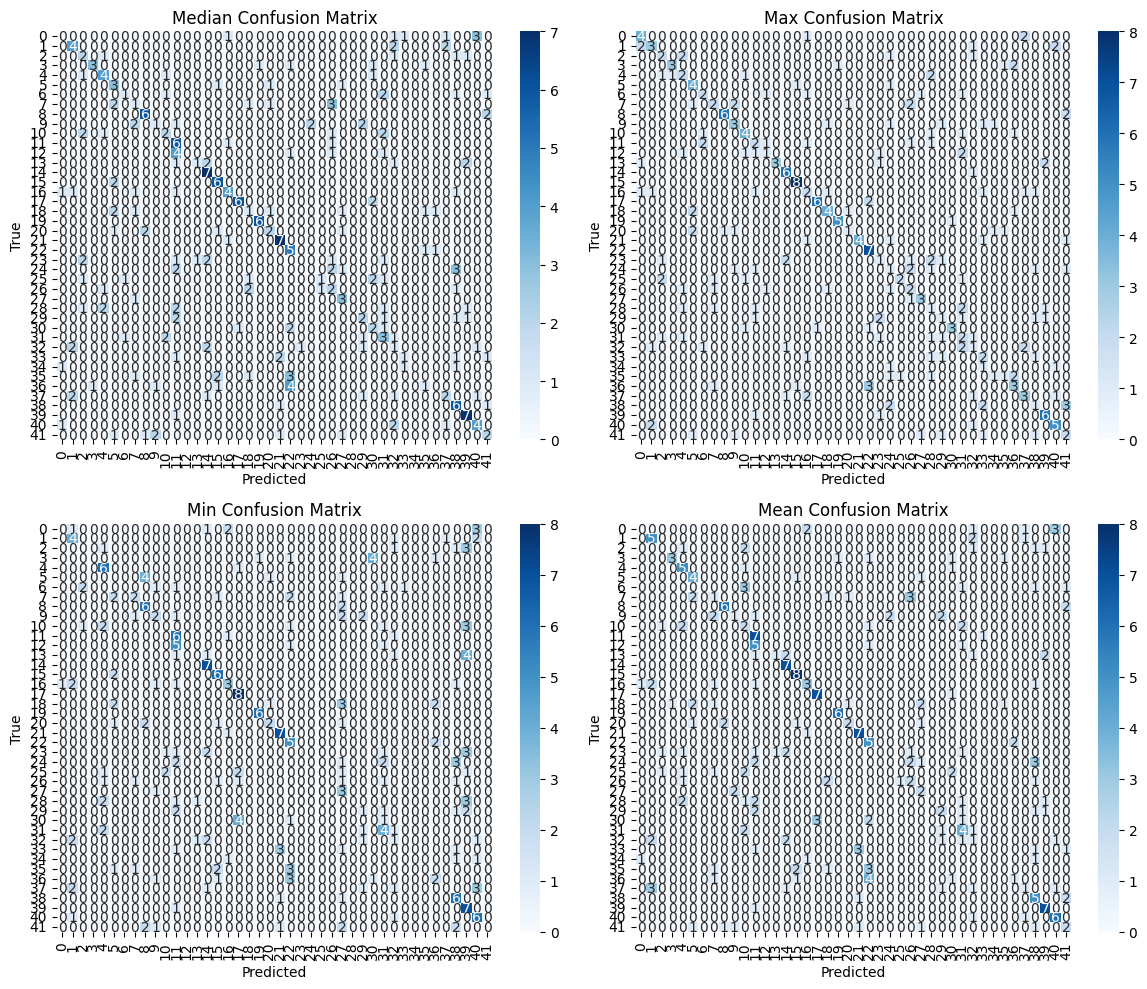

max_accuracy = 0.40924092409240925
min_accuracy = 0.33003300330033003
mean_accuracy = 0.37293729372937295
median_accuracy = 0.37623762376237624


In [6]:
model = dual_model((100, 100, 3), alexnet_model)
model.load_weights('Weights/Experiment 3/weights.95-0.48.weights.h5')

plot_cm_and_accuracies(model)

In [ ]:
import os
import glob
import random
import cv2

persons = os.listdir("DatabaseNoBackground")

for i in range(10):
    person = random.choice(persons)
    image_files = glob.glob(f"DatabaseNoBackground/{person}/*.JPG")
    
    image_a = cv2.resize(cv2.imread(random.choice(image_files)), (100, 100))
    image_b = cv2.resize(cv2.imread(random.choice(image_files)), (100, 100))
    
    # Plot images
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image A')
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Image B')
    axes[1].axis('off')
    plt.show()
    
    prediction = model.predict([tf.expand_dims(image_a, axis=0), tf.expand_dims(image_b, axis=0)])
    print(prediction)

In [ ]:
persons = os.listdir("DatabaseNoBackground")

for i in range(10):
    person_a_b = random.sample(persons, 2)
    person_a = person_a_b[0]
    person_b = person_a_b[1]
    
    image_files_a = glob.glob(f"DatabaseNoBackground/{person_a}/*.JPG")
    image_files_b = glob.glob(f"DatabaseNoBackground/{person_b}/*.JPG")
    
    image_a = cv2.resize(cv2.imread(random.choice(image_files_a)), (100, 100))
    image_b = cv2.resize(cv2.imread(random.choice(image_files_b)), (100, 100))
    
    # Plot images
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image A')
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Image B')
    axes[1].axis('off')
    plt.show()
    
    prediction = model.predict([tf.expand_dims(image_a, axis=0), tf.expand_dims(image_b, axis=0)])
    print(prediction)